#### Import packages

In [4]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

#### Load the data

In [5]:
n_lines = 10

with open('new_household_power_consumption.txt') as file:
    head = [next(file) for line in range(n_lines)]
    
display(head)

['Date-Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3\n',
 '2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0\n',
 '2006-12-16 17:25:00,5.36,0.436,233.63,23.0,0.0,1.0,16.0\n',
 '2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0\n',
 '2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0\n',
 '2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0\n',
 '2006-12-16 17:29:00,3.52,0.522,235.02,15.0,0.0,2.0,17.0\n',
 '2006-12-16 17:30:00,3.702,0.52,235.09,15.8,0.0,1.0,17.0\n',
 '2006-12-16 17:31:00,3.7,0.52,235.22,15.8,0.0,1.0,17.0\n',
 '2006-12-16 17:32:00,3.668,0.51,233.99,15.8,0.0,1.0,17.0\n']

In [6]:
df = pd.read_csv("new_household_power_consumption.txt")

##### Global Active Power

- In this example, we'll want to predict the global active power, which is the household minute-averaged active power (kilowatt), measured across the globe. So, below, I am getting just that column of data and displaying the resultant plot.

In [7]:
df['Date-Time'] = pd.to_datetime(df['Date-Time'])
df = df.set_index("Date-Time")

In [8]:
power_df = df['Global_active_power'].copy()
power_df.shape

(2075259,)

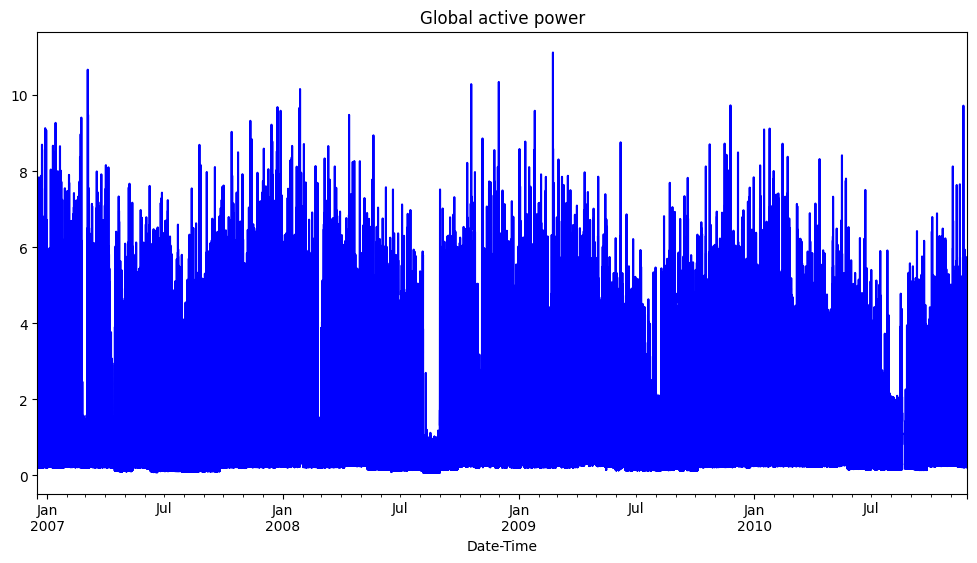

In [9]:
# display the data 
plt.figure(figsize=(12,6))
# all data points
power_df.plot(title='Global active power', color='blue') 
plt.show()

- Since the data is recorded each minute, the above plot contains a lot of values. So, I'm also showing just a slice of data, below.

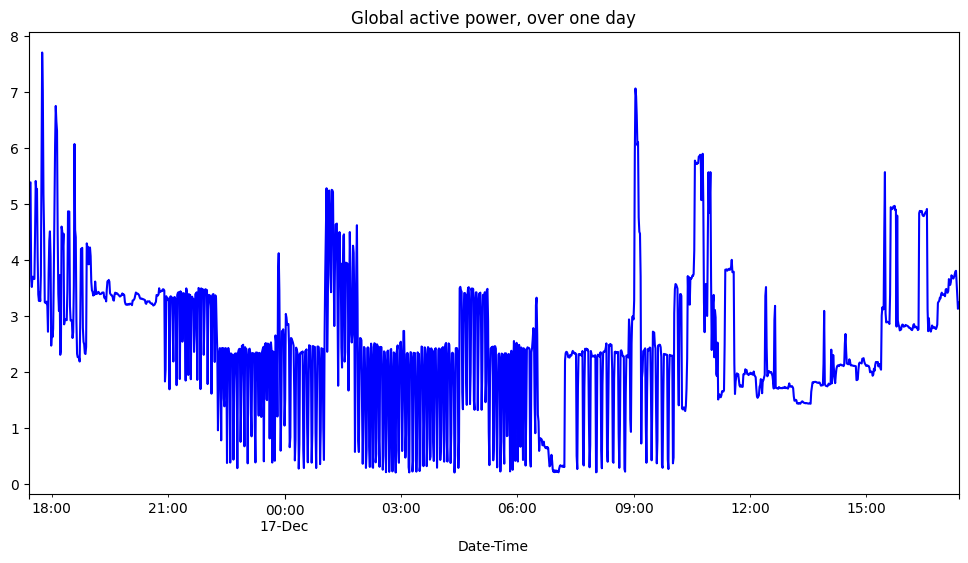

In [10]:
# can plot a slice of hourly data
end_mins = 1440 # 1440 mins = 1 day

plt.figure(figsize=(12,6))
power_df[0:end_mins].plot(title='Global active power, over one day', color='blue') 
plt.show()

 Hourly vs Daily

There is a lot of data, collected every minute, and so I could go one of two ways with my analysis:
1. Create many, short time series, say a week or so long, in which I record energy consumption every hour, and try to predict the energy consumption over the following hours or days.
2. Create fewer, long time series with data recorded daily that I could use to predict usage in the following weeks or months.

- Both tasks are interesting! It depends on whether you want to predict time patterns over a day/week or over a longer time period, like a month.
- With the amount of data I have, I think it would be interesting to see longer, recurring trends that happen over several months or over a year.
- So, I will resample the 'Global active power' values, recording daily data points as averages over 24-hr periods.

In [11]:
# resample over day (D)
freq = 'D'
# calculate the mean active power for a day
mean_power_df = power_df.resample(freq).mean()

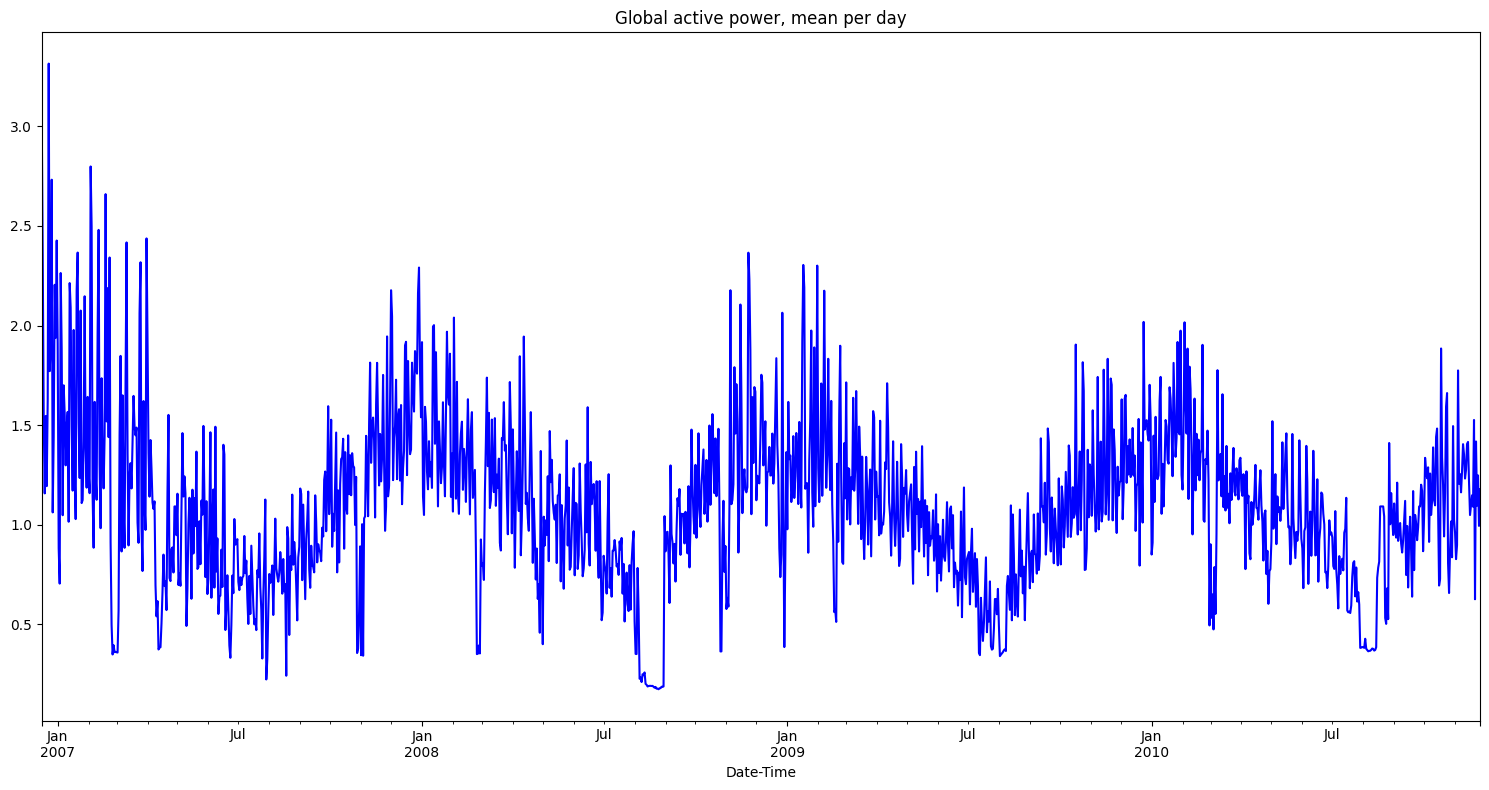

In [12]:
# display the mean values
plt.figure(figsize=(15,8))
mean_power_df.plot(title='Global active power, mean per day', color='blue')
plt.tight_layout()
plt.show()

- In this plot, we can see that there are some interesting trends that occur over each year.
- It seems that there are spikes of energy consumption around the end/beginning of each year, which correspond with heat and light usage being higher in winter months.
- We also see a dip in usage around August, when global temperatures are typically higher.

- The data is still not very smooth, but it shows noticeable trends, and so, makes for a good use case for machine learning models that may be able to recognize these patterns.

#### Create Time Series 

Our goal will be to take full years of data, from 2007-2009, and see if I can use it to accurately predict the average Global active power usage for the next several months in 2010!

Next, let's make one time series for each complete year of data. This is just a design decision, and I am deciding to use full years of data, starting in January of 2017 because there are not that many data points in 2006 and this split will make it easier to handle leap years; I could have also decided to construct time series starting at the first collected data point, just by changing `t_start` and `t_end` in the function below.

The function `make_time_series` will create pandas `Series` for each of the passed in list of years `['2007', '2008', '2009']`.
* All of the time series will start at the same time point `t_start` (or t0). 
    * When preparing data, it's important to use a consistent start point for each time series; DeepAR uses this time-point as a frame of reference, which enables it to learn recurrent patterns e.g. that weekdays behave differently from weekends or that Summer is different than Winter.
    * You can change the start and end indices to define any time series you create.
* We should account for leap years, like 2008, in the creation of time series.
* Generally, we create `Series` by getting the relevant global consumption data (from the DataFrame) and date indices.

In [13]:
def make_time_series(mean_power_df, years, freq='D', start_idx=16):
    '''Creates as many time series as there are complete years. This code
       accounts for the leap year, 2008.
      :param mean_power_df: A dataframe of global power consumption, averaged by day.
          This dataframe should also be indexed by a datetime.
      :param years: A list of years to make time series out of, ex. ['2007', '2008'].
      :param freq: The frequency of data recording (D = daily)
      :param start_idx: The starting dataframe index of the first point in the first time series.
          The default, 16, points to '2017-01-01'. 
      :return: A list of pd.Series(), time series data.
      '''

    # store time series
    time_series = []

    # store leap year in this dataset
    leap = '2008'

    # create time series for each year in years
    for i in range(len(years)):

        year = years[i]
        if (year == leap):
            end_idx = start_idx+366
        else:
            end_idx = start_idx+365

        # create start and end datetimes
        t_start = year + '-01-01'  # Jan 1st of each year = t_start
        t_end = year + '-12-31'  # Dec 31st = t_end

        # get global consumption data
        data = mean_power_df[start_idx:end_idx]

        # create time series for the year
        index = pd.DatetimeIndex(pd.date_range(
            start=t_start, end=t_end, freq=freq))
        time_series.append(pd.Series(data=data, index=index))

        start_idx = end_idx

    # return list of time series
    return time_series

In [14]:
# test out the code above

# yearly time series for our three complete years
full_years = ['2007', '2008', '2009']
freq='D' # daily recordings

# make time series
time_series = make_time_series(mean_power_df, full_years, freq=freq)

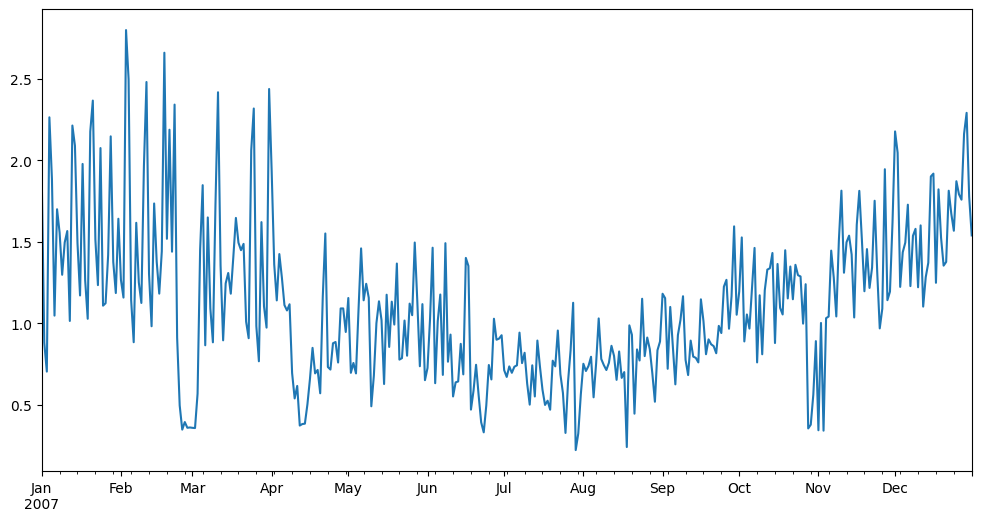

In [15]:
# display first time series
time_series_idx = 0

plt.figure(figsize=(12,6))
time_series[time_series_idx].plot()
plt.show()

#### Splitting in Time

We'll evaluate our model on a test set of data. For machine learning tasks like classification, we typically create train/test data by randomly splitting examples into different sets. For forecasting it's important to do this train/test split in **time** rather than by individual data points. 
> In general, we can create training data by taking each of our *complete* time series and leaving off the last `prediction_length` data points to create *training* time series. 

##### EXERCISE: Create training time series

Complete the `create_training_series` function, which should take in our list of complete time series data and return a list of truncated, training time series.

* In this example, we want to predict about a month's worth of data, and we'll set `prediction_length` to 30 (days).
* To create a training set of data, we'll leave out the last 30 points of *each* of the time series we just generated, so we'll use only the first part as training data. 
* The **test set contains the complete range** of each time series.

In [16]:
# create truncated, training time series
def create_training_series(complete_time_series, prediction_length):
    '''Given a complete list of time series data, create training time series.
       :param complete_time_series: A list of all complete time series.
       :param prediction_length: The number of points we want to predict.
       :return: A list of training time series.
       '''
    # get training series
    time_series_training = []

    for ts in complete_time_series:
        # truncate trailing 30 pts
        time_series_training.append(ts[:-prediction_length])

    return time_series_training

In [17]:
prediction_length = 30 # 30 days ~ a month

time_series_training = create_training_series(time_series, prediction_length)

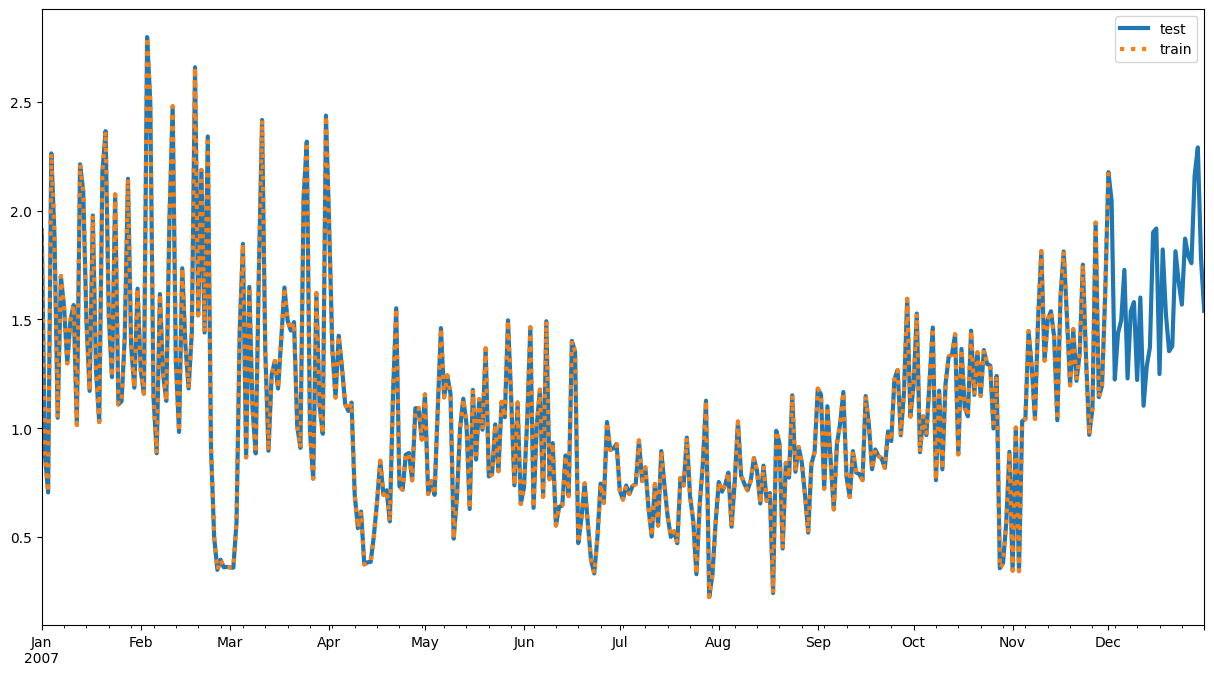

In [18]:
# display train/test time series
time_series_idx = 0

plt.figure(figsize=(15,8))
# test data is the whole time series
time_series[time_series_idx].plot(label='test', lw=3)
# train data is all but the last prediction pts
time_series_training[time_series_idx].plot(label='train', ls=':', lw=3)

plt.legend()
plt.show()

##### Convert to JSON 

According to the [DeepAR documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html), DeepAR expects to see input training data in a JSON format, with the following fields:

* **start**: A string that defines the starting date of the time series, with the format 'YYYY-MM-DD HH:MM:SS'.
* **target**: An array of numerical values that represent the time series.
* **cat** (optional): A numerical array of categorical features that can be used to encode the groups that the record belongs to. This is useful for finding models per class of item, such as in retail sales, where you might have {'shoes', 'jackets', 'pants'} encoded as categories {0, 1, 2}.

The input data should be formatted with one time series per line in a JSON file. Each line looks a bit like a dictionary, for example:
```
{"start":'2007-01-01 00:00:00', "target": [2.54, 6.3, ...], "cat": [1]}
{"start": "2012-01-30 00:00:00", "target": [1.0, -5.0, ...], "cat": [0]} 
...
```
In the above example, each time series has one, associated categorical feature and one time series feature.

##### EXERCISE: Formatting Energy Consumption Data

For our data:
* The starting date, "start," will be the index of the first row in a time series, Jan. 1st of that year.
* The "target" will be all of the energy consumption values that our time series holds.
* We will not use the optional "cat" field.

Complete the following utility function, which should convert `pandas.Series` objects into the appropriate JSON strings that DeepAR can consume.

In [19]:
def series_to_json_obj(ts):
    '''Returns a dictionary of values in DeepAR, JSON format.
       :param ts: A single time series.
       :return: A dictionary of values with "start" and "target" keys.
       '''
    # get start time and target from the time series, ts
    json_obj = {"start": str(ts.index[0]), "target": list(ts)}
    return json_obj

In [20]:
ts = time_series[0]
json_obj = series_to_json_obj(ts)

#### Saving Data, Locally

The next helper function will write one series to a single JSON line, using the new line character '\n'. The data is also encoded and written to a filename that we specify.

In [21]:
# import json for formatting data
import json
import os # and os for saving

def write_json_dataset(time_series, filename): 
    with open(filename, 'wb') as f:
        # for each of our times series, there is one JSON line
        for ts in time_series:
            json_line = json.dumps(series_to_json_obj(ts)) + '\n'
            json_line = json_line.encode('utf-8')
            f.write(json_line)
    print(filename + ' saved.')

In [22]:
data_dir = 'json_energy_data'
os.makedirs('json_energy_data', exist_ok=True)

In [23]:
# directories to save train/test data
train_key = os.path.join(data_dir, 'train.json')
test_key = os.path.join(data_dir, 'test.json')

# write train/test JSON files
write_json_dataset(time_series_training, train_key)        
write_json_dataset(time_series, test_key)

json_energy_data/train.json saved.
json_energy_data/test.json saved.
